In [1]:
import sys
sys.path.insert(0, '..')

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from skimage.measure import label,regionprops
from skimage.transform import rescale

import dognet
import torch
from torch.autograd import Variable
from skimage.draw import circle

### Load collman small dataset

This dataset has only three channels: Synapsin, vGlut and PSD-95, rescaled to fit Weiler14 resolution.

In [2]:
collman = np.load('../datasets/collman15/collman_small.npy')

In [3]:
def inference(net,image):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    res,_ = net(vx)
    return res.data.cpu().numpy()

def make_labels(img,xs,ys,radius=2):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(yv,xv,radius)
        labels[rr,cc]=1
    return labels

def load_annotation(path,scale):
    anno = np.load(path)['collman15v2_annotation']
    
    layer = []
    for i in range(anno.shape[0]):
        props = regionprops(anno[i])
        yy = [p.centroid[0] * scale for p in props]
        xx = [p.centroid[1] * scale for p in props]
        layer.append([xx, yy])
    return layer

### Load of the annotation and making a training set

In [4]:
layer = load_annotation('../datasets/collman15/collman15v2_annotation.npz',2.23e-9/1e-7)

#Train set
train_images = []
train_labels = []
for i in range(9,14):
    d = make_labels(collman[:,0],layer[i][0],layer[i][1])
    train_images.append(collman[:,i-2:i+2].mean(axis=1))
    train_labels.append(d)

### Training DoGNet on Collman15

with CUDA
Training started!
[====================] 100%
Training finished!


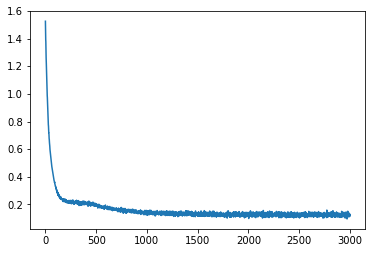

In [5]:
n = dognet.SimpleAnisotropic(3,9,2,return_intermediate=True,learn_amplitude=False)
n.weights_init()
if torch.cuda.is_available():
    print('with CUDA')
    n = n.cuda()
else:
    print('CUDA is not detected, running on CPU')
net,errors =dognet.train_routine(n,dognet.create_generator(train_images,train_labels),n_iter=3000,margin=3)
plt.plot(errors)

### Plot result on Collman dataset

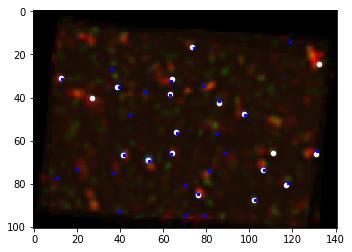

In [6]:
silce = 20

x = collman[:,silce-2:silce+2].mean(axis=1)
y  = inference(net,x)

img = x.transpose((1,2,0))*2.
img = np.dstack( (img, np.ones_like(x[0])*1. ) )
plt.imshow(img)
gt_pts = np.array([layer[silce][0],layer[silce][1]]).transpose(1,0)
coords = np.array([ list(p.centroid) for p in regionprops(label(y[0,0]>0.3)) if p.area>3])
plt.scatter(coords[:,1],coords[:,0],s=20, c='white', marker='o')
plt.scatter(gt_pts[:,0],gt_pts[:,1],s=7, c='blue', marker='x')

### Load Weiler dataset 

The repacked dataset contains only 'Ex3R43C2_Synapsin1_3', 'Ex3R43C2_vGluT1_2', 'Ex3R43C2_PSD95_2' channels for 3 first slices.

In [15]:
weiler = np.load('../datasets/weiler14/weiler.npz')['weiler']

In [8]:
# Domain shift to fit collman statistics

new_weiler = []
for i in range(3):
    frag = collman[i,0,20:80,20:100]
    intfrag = weiler[i,0,300:900,350:900]
    k = (np.std(frag)/np.std(intfrag))
    shift = (np.mean(frag)-np.mean(intfrag))
    wfrag = intfrag*k+shift
    
    domain_shift = []
    for j in range(weiler.shape[1]):
        domain_shift.append(weiler[i,j]*k+shift)
        
    new_weiler.append(np.stack(domain_shift))
new_weiler = np.stack(new_weiler)

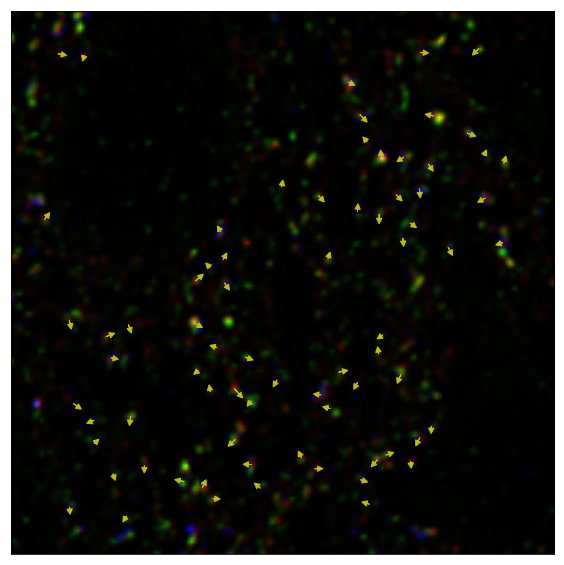

In [9]:
from matplotlib.patches import Rectangle,Ellipse
from scipy.io import savemat
sample = np.mean(new_weiler[:,:,300:500,700:900],axis=1)
res = inference(net,sample.astype(float))
xx,yy,_ = dognet.find_peaks(res[0,0],3)

#Extract descriptors
syn = dognet.extract_descriptor(sample[0],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)
psd = dognet.extract_descriptor(sample[2],
                                xx,yy,window_size=3,get_gaussian=dognet.get_gaussian)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))


plt.setp(axes, xticks=[], yticks=[])
samplex = np.transpose(sample,(1,2,0))
samplex = (samplex-np.min(samplex,(0,1)))/(np.max(samplex,(0,1))-np.min(samplex,(0,1))).astype(np.float)
axes.imshow(samplex,interpolation='bilinear')

for s,p in zip(syn,psd):
    axes.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=2., head_length=2., fc='y', ec='y')


### Estimate F1 score with expert annotation

0.754716981132
0.884615384615


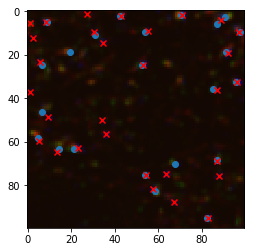

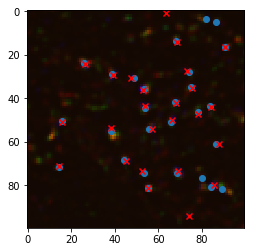

In [65]:
from scipy.io import loadmat

annotations = ['../datasets/weiler14/weiler300400_400500.mat',
               '../datasets/weiler14/weiler300400_800900.mat']

for a in annotations:
    annotation = loadmat(a)
    img = np.array(annotation["RGB_image"])
    res = inference(net,img.transpose(2,0,1))
    
    gt_pts = np.array([[x,y] for x,y in zip(annotation["X"][0,1:]-1.,annotation["Y"][0,1:]-1.)])
    coords = np.array([ list(p.centroid) for p in regionprops(label(res[0,0]>0.5)) if p.area>0])
    dog_pts = np.array([coords[:,1],coords[:,0]]).transpose(1,0)
    precision,recall,f1_score,_ = dognet.get_metric(gt_pts,dog_pts,s=4.)
    
    print(f1_score)

    plt.figure()
    plt.imshow(img)
    plt.scatter(gt_pts[:,0],gt_pts[:,1])
    plt.scatter(dog_pts[:,0],dog_pts[:,1],marker='x',color='red')

### Descriptor export

In [22]:
import pandas as pd
from skimage.io import imsave
name = 'weiler'
req_channels=['Ex3R43C2_Synapsin1_3', 'Ex3R43C2_vGluT1_2', 'Ex3R43C2_PSD95_2']
dm=[]
for silce in range(1,2):
    x = new_weiler[:,silce-2:silce+2].mean(axis=1).astype(np.float32)
    y  = inference(net,x)
    xx,yy,_ = dognet.find_peaks(y[0,0],3)
    
    imsave("../results/weiler_prob_"+str(silce)+".png",y[0,0])
    pic = x[:3].transpose(1,2,0)
    
    pic = np.copy(pic)
    pic[pic>0.5]=0.5
    pic = (pic-np.min(pic,(0,1)))/(np.max(pic,(0,1))-np.min(pic,(0,1))).astype(np.float)
    for x,y in zip(xx,yy):
        x = int(x)
        y = int(y)
        pic[x-1:x+2,y,0]=1
        pic[x-1:x+2,y,1]=1
        pic[x-1:x+2,y,2]=0
        pic[x,y-1:y+2,0]=1
        pic[x,y-1:y+2,1]=1
        pic[x,y-1:y+2,2]=0
    imsave("../results/weiler_loc_"+str(silce)+".png",pic)
    for c in range(len(req_channels)):    
            desc = dognet.extract_descriptor(weiler[c,silce-2:silce+2].mean(axis=0),xx,yy,3)   
            dm+=[[silce,req_channels[c]]+d for d in desc]
            
dm = np.array(dm)            
d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
     ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
     'x_dog': dm[:,11],'y_dog': dm[:,12]}
df = pd.DataFrame(data=d)
df.to_csv(name+".csv")